## Task 5 - Modelling

In [1]:
import os
import sys
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import scorecardpy as sc
current_dir = os.getcwd()

# Append the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# ignore warrnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
final_merged_df=pd.read_csv('../data/final_merged_data.csv')

In [3]:
final_merged_df

,CustomerId,Total_Transaction_Amount,Avg_Transaction_Amount,Transaction_Count,Std_Transaction_Amount,Amount,Value,PricingStrategy,ChannelId1,ChannelId2,ChannelId3,ChannelId5,FraudResult,Risk_category
0,CustomerId_1,0.556885,0.045974,1,0.005449,0.090993,0.001012,4,0,1,0,0,0,bad
1,CustomerId_10,0.556885,0.045974,1,0.005449,0.090993,0.001012,4,0,1,0,0,0,bad
2,CustomerId_1001,0.557044,0.047525,5,0.001982,0.092831,0.001012,2,0,0,1,0,0,bad
3,CustomerId_1002,0.556961,0.047124,11,0.000169,0.092050,0.000152,4,0,0,1,0,0,good
4,CustomerId_1003,0.557044,0.047451,6,0.001822,0.092831,0.001012,2,0,0,1,0,0,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,CustomerId_992,0.557044,0.047451,6,0.001839,0.092831,0.001012,2,0,0,1,0,0,bad
3738,CustomerId_993,0.557044,0.047525,5,0.002038,0.092831,0.001012,2,0,0,1,0,0,bad
3739,CustomerId_994,0.559826,0.047678,101,0.004472,0.092004,0.000101,2,0,0,1,0,0,good
3740,CustomerId_996,0.557676,0.047988,17,0.001339,0.092831,0.001012,2,0,0,1,0,0,bad


In [4]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
final_merged_df['Risk_category'] = label_encoder.fit_transform(final_merged_df['Risk_category'])

In [5]:
from scripts.model_development_scripts import ModelEvaluator

In [6]:
trainer=ModelEvaluator(final_merged_df,'Risk_category')

### Model Selection and Training

#### 1. Split the Data
- **Objective:** Split the data into training and testing sets to ensure the model's performance is evaluated on unseen data.
- **Method:** Use `train_test_split` from `sklearn` to split the final merged dataset into a training set (for model learning) and a testing set (for performance evaluation).

In [7]:
X_train, X_test,y_train,y_test = trainer.split_data()

Data split into training and testing sets.


### 2. Choose Models
- **Objective**: Train at least two models from the following:
    - Logistic Regression
    - Decision Trees
    - Random Forest

### Train Logistic Regression

Fit the Logistic Regression model using the training data.

``` python
 param_grid = {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l2', 'none'],
            'solver': ['lbfgs', 'newton-cg', 'saga']
        }

In [8]:
logistic_model = trainer.train_logistic_regression()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Logistic Regression model trained with hyperparameter tuning.
Best parameters found: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


In [9]:
# Print the coefficients
logistic_model.coef_

array([[-1.01552134e-02, -8.99950974e-04,  9.50991714e-03,
        -1.17592489e-04, -1.72681475e-03, -6.47915371e-05,
        -4.47807768e-02, -4.63698784e-04, -3.28386490e-04,
        -1.73218732e-02, -8.41941537e-05, -2.15226731e-04]])

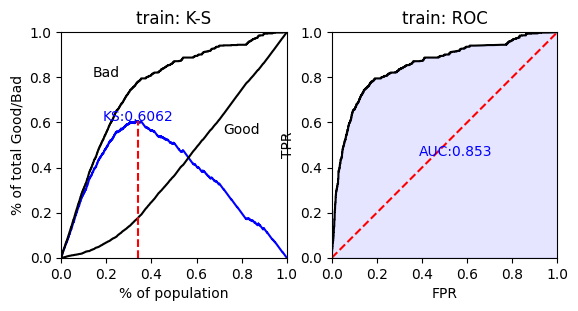

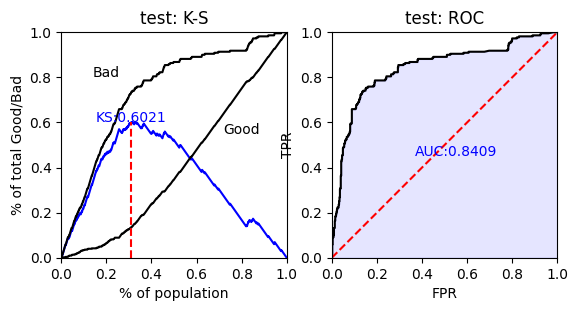

In [10]:
# predicted proability
train_pred = logistic_model.predict_proba(X_train)[:,1]
test_pred = logistic_model.predict_proba(X_test)[:,1]

# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, roc_curve

predictions = logistic_model.predict(X_test)

print('Accuracy')
print(accuracy_score(y_test, predictions))
print('AUC Score')
print(roc_auc_score(y_test, predictions))

Accuracy
0.8184245660881175
AUC Score
0.7957853583089879


In [12]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       529
           1       0.67      0.74      0.71       220

    accuracy                           0.82       749
   macro avg       0.78      0.80      0.79       749
weighted avg       0.82      0.82      0.82       749



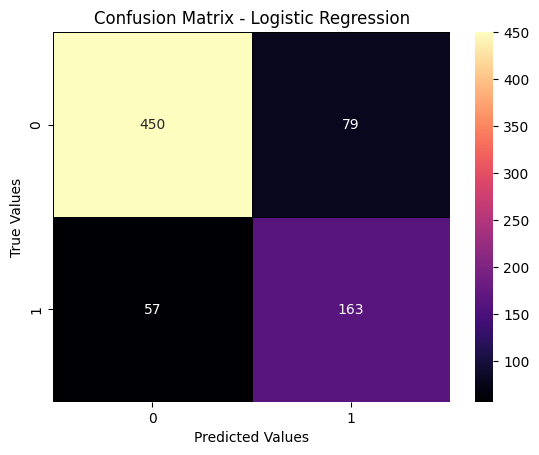

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_log2 = confusion_matrix(y_test,predictions)
sns.heatmap(data=conf_log2, annot=True, linewidth=0.7, linecolor='k', fmt='.0f', cmap='magma')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix - Logistic Regression');

#### Train Random Forest
Fit the Random Forest model using the training data.

``` python
param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }

In [14]:
rf_model =trainer.train_random_forest()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Random Forest model trained with hyperparameter tuning.
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


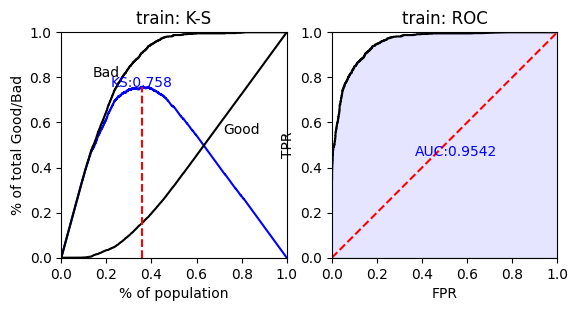

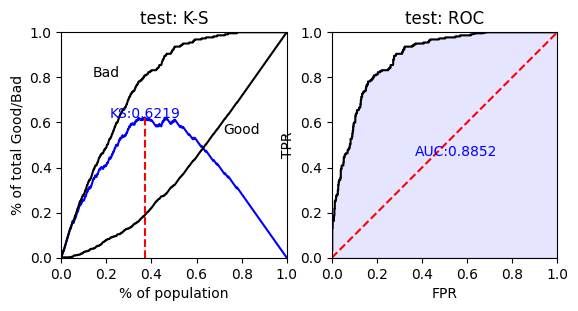

In [15]:
# predicted proability
train_pred_rf = rf_model.predict_proba(X_train)[:,1]
test_pred_rf = rf_model.predict_proba(X_test)[:,1]

# performance ks & roc ------
train_perf_rf = sc.perf_eva(y_train, train_pred_rf, title = "train")
test_perf_rf = sc.perf_eva(y_test, test_pred_rf, title = "test")

In [16]:
from sklearn.metrics import classification_report
rf_predictions = rf_model.predict(X_test)

print('Accuracy')
print(accuracy_score(y_test, rf_predictions))
print('AUC Score')
print(roc_auc_score(y_test, rf_predictions))

print(classification_report(y_test, rf_predictions))

Accuracy
0.8104138851802403
AUC Score
0.7436501117030417
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       529
           1       0.72      0.58      0.64       220

    accuracy                           0.81       749
   macro avg       0.78      0.74      0.76       749
weighted avg       0.80      0.81      0.80       749



### Model Evaluation

#### Metrics:
- **Accuracy**: The ratio of correctly predicted observations to the total observations.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall (Sensitivity)**: The ratio of correctly predicted positive observations to all actual positives.
- **F1 Score**: The weighted average of Precision and Recall.
- **ROC-AUC**: Area Under the Receiver Operating Characteristic Curve, measures the ability to distinguish between classes.

In [17]:
# Predictions
y_pred_logistic = logistic_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation Reports
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_logistic))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

# ROC-AUC - For binary classification (need probabilities)
y_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

roc_auc_logistic = roc_auc_score(y_test, y_proba_logistic)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Logistic Regression ROC-AUC: {roc_auc_logistic:.2f}")
print(f"Random Forest ROC-AUC: {roc_auc_rf:.2f}")


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       529
           1       0.67      0.74      0.71       220

    accuracy                           0.82       749
   macro avg       0.78      0.80      0.79       749
weighted avg       0.82      0.82      0.82       749

Random Forest Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       529
           1       0.72      0.58      0.64       220

    accuracy                           0.81       749
   macro avg       0.78      0.74      0.76       749
weighted avg       0.80      0.81      0.80       749

Logistic Regression ROC-AUC: 0.84
Random Forest ROC-AUC: 0.89


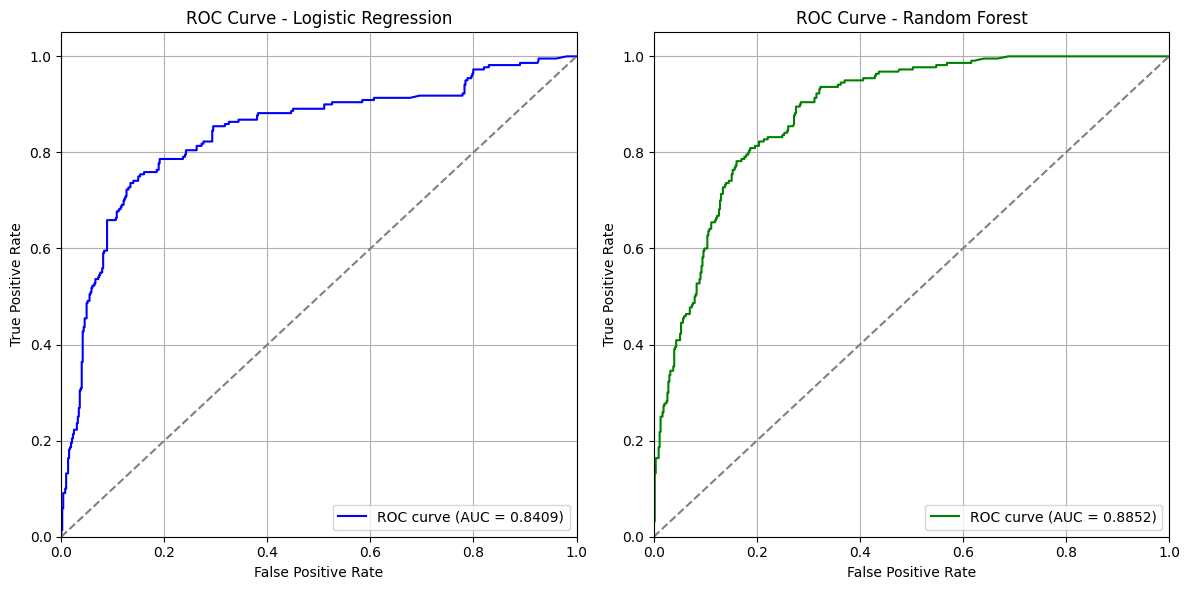

In [18]:
models = {
    'Logistic Regression': logistic_model,
    'Random Forest': rf_model
}
trainer.plot_roc_curves(models, X_test, y_test)


In [19]:
trainer.display_classification_reports(models,X_test,y_test)

Classification report generated for Logistic Regression:

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       529
           1       0.67      0.74      0.71       220

    accuracy                           0.82       749
   macro avg       0.78      0.80      0.79       749
weighted avg       0.82      0.82      0.82       749

Classification report generated for Random Forest:

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       529
           1       0.72      0.58      0.64       220

    accuracy                           0.81       749
   macro avg       0.78      0.74      0.76       749
weighted avg       0.80      0.81      0.80       749



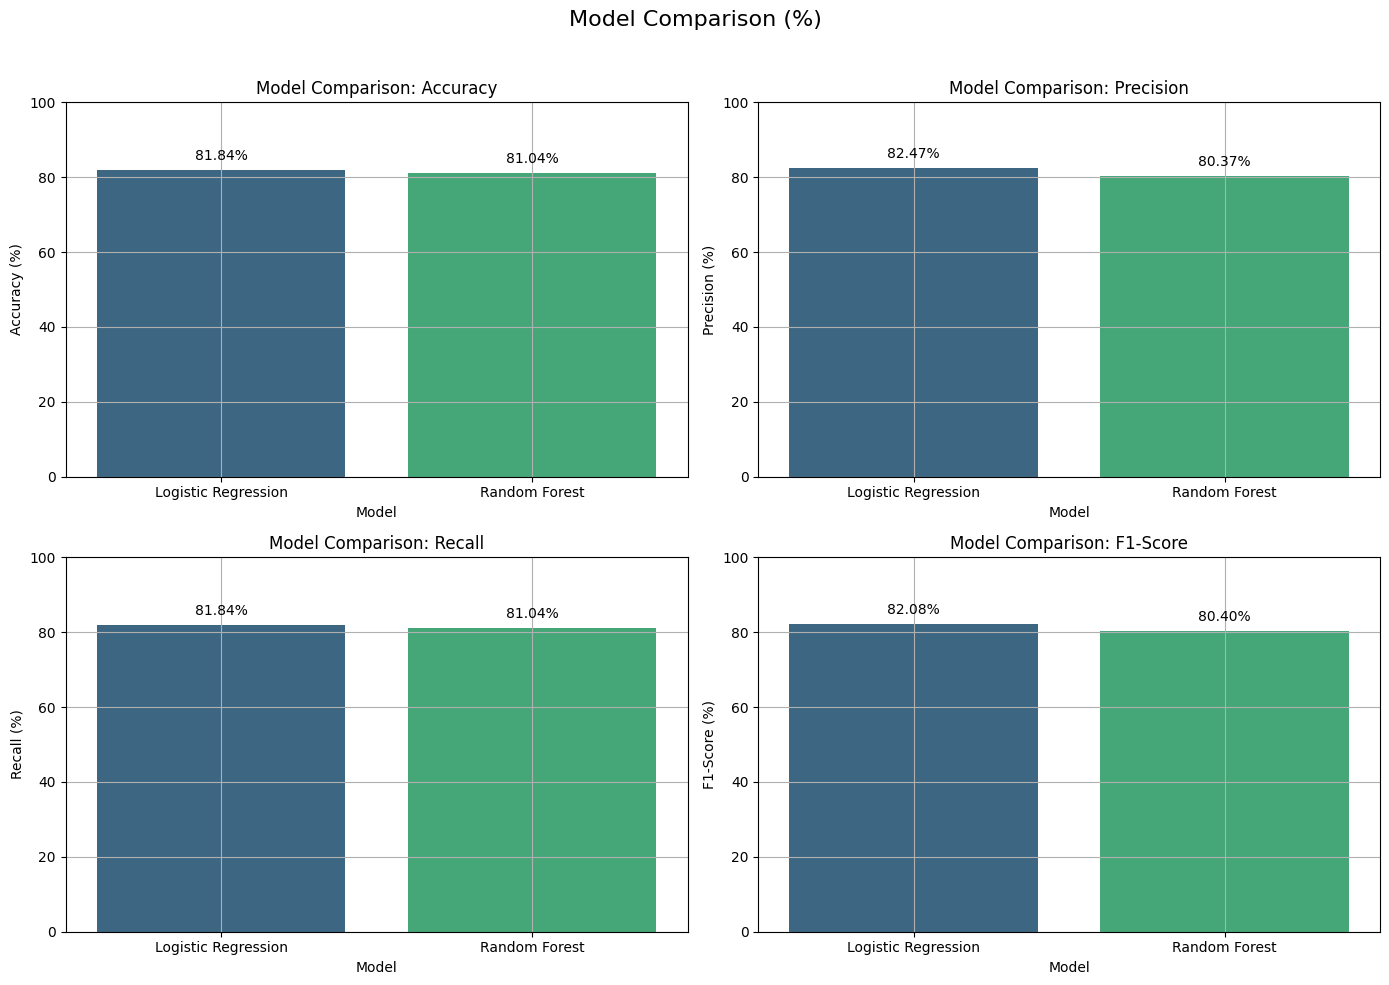

In [20]:
trainer.plot_model_comparisons(models, X_test, y_test)

In [21]:
# Saving selected Model to disk
trainer.save_model(models, 'logistic_regression')

logistic_regression model saved to models\logistic_regression.pkl
